In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow.keras.models as models

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2135 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) # 67*32

67

In [6]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    

(32, 256, 256, 3)
[0 1 0 0 0 1 1 1 0 2 1 0 0 0 0 2 1 1 1 2 1 1 0 1 0 0 1 1 0 1 0 0]


In [7]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[174. 165. 168.]
  [173. 164. 167.]
  [172. 163. 166.]
  ...
  [153. 142. 148.]
  [155. 144. 150.]
  [157. 146. 152.]]

 [[174. 165. 168.]
  [173. 164. 167.]
  [172. 163. 166.]
  ...
  [154. 143. 149.]
  [154. 143. 149.]
  [155. 144. 150.]]

 [[174. 165. 168.]
  [174. 165. 168.]
  [173. 164. 167.]
  ...
  [156. 145. 151.]
  [155. 144. 150.]
  [153. 142. 148.]]

 ...

 [[149. 135. 134.]
  [143. 129. 128.]
  [150. 136. 135.]
  ...
  [125. 113. 113.]
  [130. 118. 118.]
  [131. 119. 119.]]

 [[144. 130. 129.]
  [139. 125. 124.]
  [147. 133. 132.]
  ...
  [120. 108. 108.]
  [122. 110. 110.]
  [121. 109. 109.]]

 [[157. 143. 142.]
  [152. 138. 137.]
  [157. 143. 142.]
  ...
  [135. 123. 123.]
  [133. 121. 121.]
  [130. 118. 118.]]]


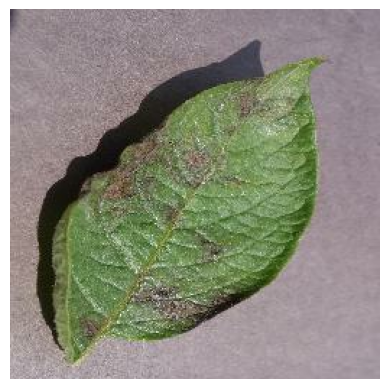

In [8]:
for image_batch , label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")

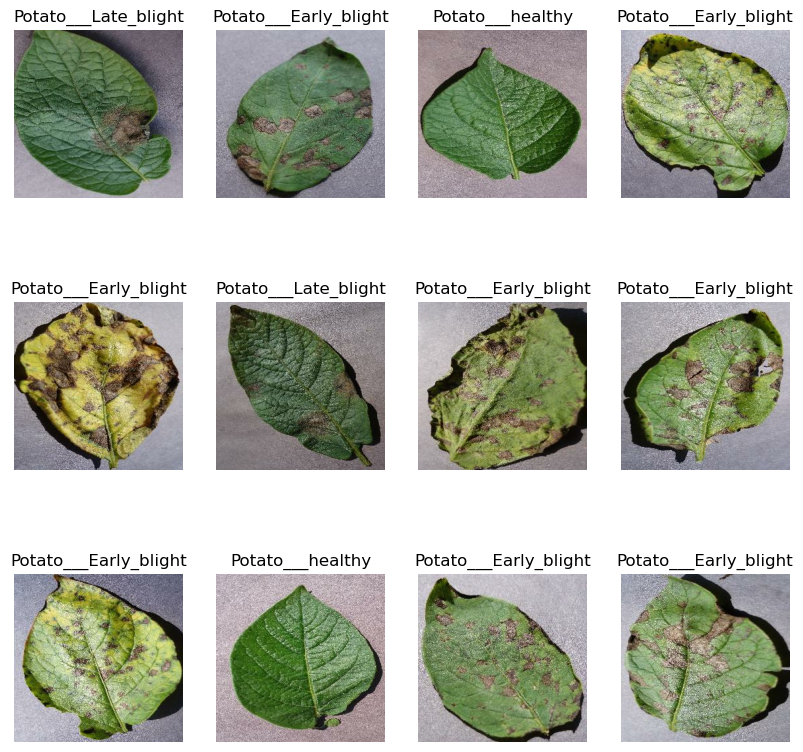

In [9]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,val_split=0.1,
                              shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
        
    return train_ds,test_ds,val_ds

In [11]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [12]:
print(len(train_ds),len(test_ds),len(val_ds))

53 6 8


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
n_classes = 3
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D( 32 , (3,3) , activation='relu' , input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D( (2,2) ),
    layers.Conv2D( 64 , kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D( (2,2) ),
    layers.Conv2D( 64 , kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D( (2,2) ),
    layers.Conv2D( 64 , (3,3) , activation='relu' ),
    layers.MaxPooling2D( (2,2) ),
    layers.Conv2D( 64 , (3,3) , activation='relu' ),
    layers.MaxPooling2D( (2,2) ),
    layers.Conv2D( 64 , (3,3) , activation='relu' ),
    layers.MaxPooling2D( (2,2) ),
    layers.Flatten(),
    layers.Dense(64 , activation='relu'),
    layers.Dense(n_classes , activation='softmax')
    
])

In [17]:
model.build(input_shape = input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['Accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
53/53 [==============================] - 228s 4s/step - loss: 0.8928 - Accuracy: 0.4873 - val_loss: 0.8034 - val_Accuracy: 0.6602
Epoch 2/50
53/53 [==============================] - 186s 4s/step - loss: 0.6175 - Accuracy: 0.7244 - val_loss: 0.5989 - val_Accuracy: 0.7383
Epoch 3/50
53/53 [==============================] - 181s 3s/step - loss: 0.3867 - Accuracy: 0.8400 - val_loss: 0.4400 - val_Accuracy: 0.8281
Epoch 4/50
53/53 [==============================] - 180s 3s/step - loss: 0.3400 - Accuracy: 0.8696 - val_loss: 0.3149 - val_Accuracy: 0.8711
Epoch 5/50
53/53 [==============================] - 191s 4s/step - loss: 0.2537 - Accuracy: 0.8951 - val_loss: 0.2621 - val_Accuracy: 0.8906
Epoch 6/50
53/53 [==============================] - 179s 3s/step - loss: 0.2363 - Accuracy: 0.9158 - val_loss: 0.3517 - val_Accuracy: 0.8516
Epoch 7/50
53/53 [==============================] - 174s 3s/step - loss: 0.2000 - Accuracy: 0.9223 - val_loss: 0.2045 - val_Accuracy: 0.9219
Epoch 8/50
53

In [30]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 3s 287ms/step - loss: 0.0060 - Accuracy: 1.0000


In [35]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

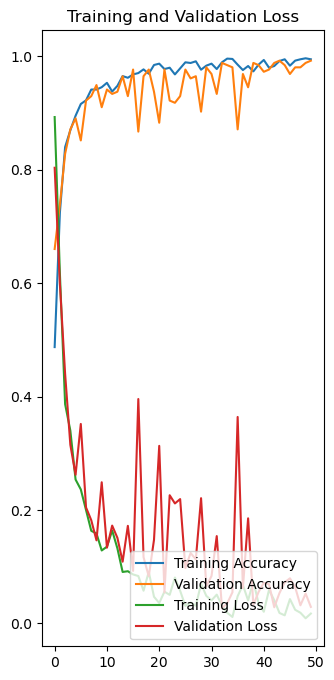

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label:  Potato___Late_blight
1/1 [==============================] - 0s 275ms/step
Predicted label:  Potato___Late_blight


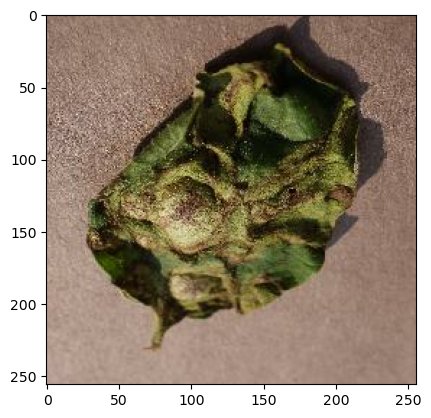

In [38]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label: ',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('Predicted label: ',class_names[np.argmax(batch_prediction[0])])
    

In [46]:
def predict(model_img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence
    

In [55]:
print(history.history.keys())

dict_keys(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'])


1/1 [==============================] - 0s 30ms/step


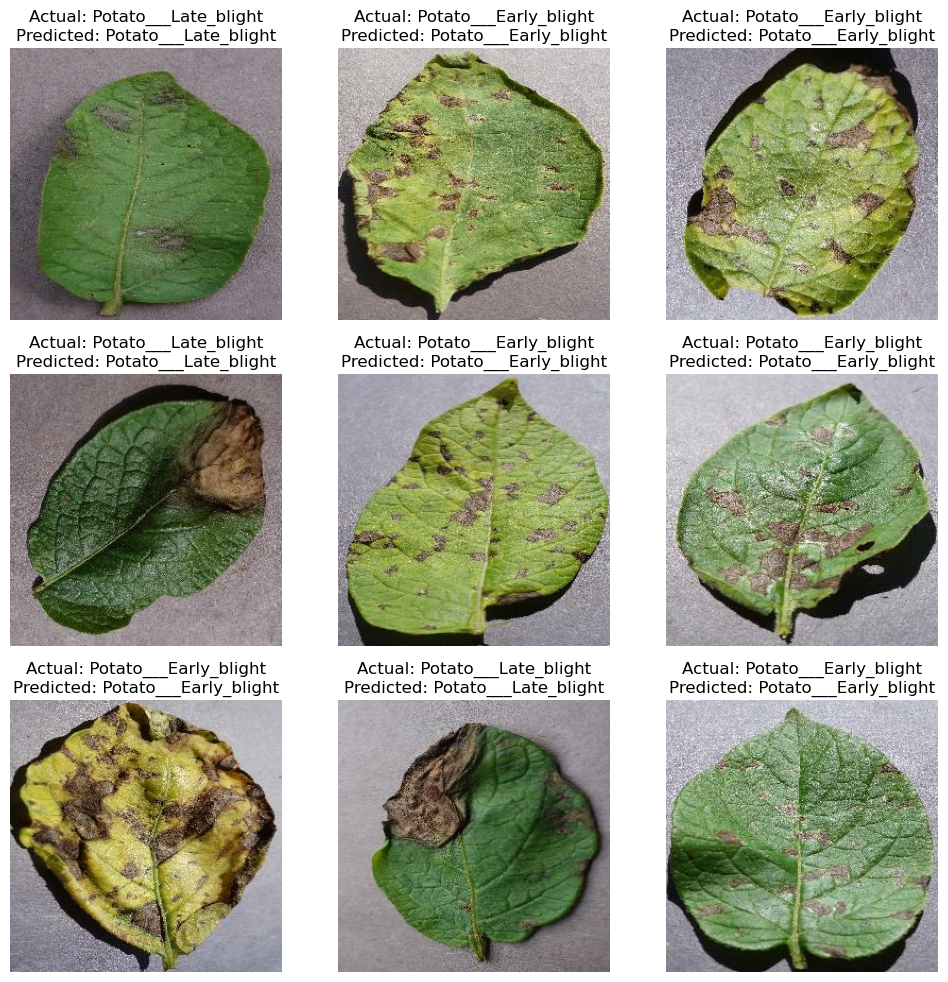

In [54]:
plt.figure(figsize=(12, 12))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predictions = model.predict(images[i][tf.newaxis, ...])  # Tek bir örnek için tahmin yapın
        predicted_class = class_names[tf.argmax(predictions, axis=1).numpy()[0]]
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}')
        plt.axis('off')


In [56]:
model_version = 2
model.save(f'../Models/{model_version}')


INFO:tensorflow:Assets written to: ../Models/2\assets


INFO:tensorflow:Assets written to: ../Models/2\assets


dict_keys(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'])
